# 第六章 风险预测

## 6.1 导言

普通投资者和专业投资者的区别就在于，普通投资者往往只预测收益，而专业投资者往往还要预测风险。
收益和风险是投资这个天枰的两端，专业投资者需要同时预测二者，并加以权衡。

如果说收益预测是一门艺术的话，风险预测则是地地道道的数学了。二者都很难，但难点不同：收益预测往往需要扎实的金融功底和一点点的灵光一现；风险预测则需要扎实的数学功底和严谨的科学素养。由于篇幅有限，本章将忽略风险预测中的理论推导，直接给出当前业内通行的风险预测模型框架，并和读者一起编程实现该框架下的一种简单风险预测模型。

我们将和读者一起完成一个股票风险预测模型，
模型比较简单，我们将使用Fama-French三因子模型来对风险建模。
事实上，业界流行的模型大约有50-100个因子。
当然，其中绝大部分是行业因子，这也完全可以理解。
我们虽然只使用三个因子，但我们演示的做法，
是适用于任意数量的因子的，只是细节不同罢了。

## 6.2 基础知识准备

在本实验中，我们将基于Fama-French三因子模型来实现股票风险预测模型。
我们先回顾一下Fama-French三因子模型：
$$ \mathbf{E}[R_i - R_f] = \beta_i \cdot \mathbf{E}[R_m - Rf] + s_i \cdot \mathbf{E}[SMB] + h_i \cdot \mathbf{E}[HML] $$
如果说股票的收益率可以分解为市场收益率、市值因子组合收益率、账面市值比因子组合收益率的话，
股票的风险也应当可以分解为市场风险、市值因子风险、账面市值比风险，以及每只股票的独有风险。

那么，怎样基于Fama-French三因子模型来建立股票风险预测模型呢？

首先，我们引入一个平凡的假设：
$$ r_i = \mathbf{E}[r_i] + \sum_k \beta_{ik} \cdot (F_k - \mathbf{E}[F_k]) + \varepsilon_i $$
其中，$r_i = R_i - R_f$。

这就是说，对于股票$i$，其超额收益应该等于其超额收益的期望与各因子的影响之和。
而因子$k$的影响等于股票$i$在因子$k$上的暴露与因子收益率在预期外的部分之乘积。

由此假设，我们可以推出股票$i$与股票$j$的协方差：
$$ \mathbf{Cov}(r_i, r_j) = \sum_{k_1, k_2} \beta_{ik_1} \cdot \mathbf{Cov}(F_{k_1}, F_{k_2}) \cdot \beta_{jk_2} + u_{ij} $$
其中，$u_{ij}$是二者不能被模型解释的独特协方差。

而股票间的协方差矩阵由此可以算出，这就是我们要预测的目标——股票的风险。

同时，Fama-French三因子模型正好为我们提供了三个有效的因子，故我们基于此，编程构建一个简单的三因子风险模型。

## 6.3 操作总览

本实验由以下几个步骤组成：
1. 步骤一：构造市场因子
2. 步骤二：构造规模因子
3. 步骤三：构造成长因子
4. 步骤四：计算风险——协方差矩阵

## 6.4 操作流程

### 6.4.0 准备工作

和前面的章节一样，本章的代码也是可以独立运行的，所以我们需要先做一些准备工作。

首先，我们导入包：

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels import api

import tushare as ts

然后我们获取股票数据和上证50指数数据：

In [3]:
stock_list = ts.get_sz50s().code
stock_data = {}
for stock in stock_list:
    stock_data[stock] = ts.get_k_data(stock, start='2017-01-01', end='2017-12-31')
    
index_name = '000016'
index_data = ts.get_k_data(index_name, index=True, start='2017-01-01', end='2017-12-31')

C:\Users\huang\Anaconda3\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


整理数据：

In [4]:
#整理股票数据
stock_0 = pd.DataFrame(index=index_data.date)
stock_na = pd.DataFrame(index=index_data.date)
stock_open = stock_0.copy()
stock_high = stock_0.copy()
stock_low = stock_0.copy()
stock_close = stock_0.copy()

for stock in stock_list:
    stock_0 = stock_0.join(pd.DataFrame(0.0, index=stock_data[stock].date, columns=[stock]))
    stock_na = stock_na.join(pd.DataFrame(stock_data[stock].open.isna().values, index=stock_data[stock].date, columns=[stock]))
    stock_open = stock_open.join(pd.DataFrame(stock_data[stock].open.values, index=stock_data[stock].date, columns=[stock]))
    stock_high = stock_high.join(pd.DataFrame(stock_data[stock].high.values, index=stock_data[stock].date, columns=[stock]))
    stock_low = stock_low.join(pd.DataFrame(stock_data[stock].low.values, index=stock_data[stock].date, columns=[stock]))
    stock_close = stock_close.join(pd.DataFrame(stock_data[stock].close.values, index=stock_data[stock].date, columns=[stock]))
    
stock_rtn = stock_0.copy()
for stock in stock_list:
    stock_rtn[stock] = stock_close[stock] / stock_close[stock].shift() - 1
stock_rtn = stock_rtn.fillna(0)

#整理指数数据
index_0 = pd.DataFrame(0.0, index=index_data.date, columns=[index_name])
index_open = pd.DataFrame(index_data.open.values, index=index_data.date, columns=[index_name])
index_high = pd.DataFrame(index_data.high.values, index=index_data.date, columns=[index_name])
index_low = pd.DataFrame(index_data.low.values, index=index_data.date, columns=[index_name])
index_close = pd.DataFrame(index_data.close.values, index=index_data.date, columns=[index_name])

index_rtn = index_close / index_close.shift() - 1
index_rtn = index_rtn.fillna(0)

#计算主动收益率
stock_active_rtn = stock_rtn - np.repeat(index_rtn.values, stock_rtn.columns.size, axis=1)
stock_active_rtn_std = stock_active_rtn.std()

### 6.4.1 步骤一：构造市场因子

做好准备工作之后，我们首先来构造市场因子。
市场因子的影响非常大，是人们发现的第一个风险因子。
单因素模型就是用于刻画市场因子对股票风险的影响。

在本节中，我们所说的构造市场因子，就是去找到股票对于市场的$\beta$。
我们先构造一个函数，利用20日的收益率数据，估计某日的$\beta$：

In [5]:
def cal_beta_1s1d(stock, n):
    if n < 3:
        return 1.0
    elif n < 20:
        return stats.linregress(index_rtn[index_name][0:n - 1], stock_rtn[stock][0:n - 1]).slope
    else:
        return stats.linregress(index_rtn[index_name][n - 20:n - 1], stock_rtn[stock][n - 20:n - 1]).slope        

print(cal_beta_1s1d('600000', 50))

0.8022969172557611


上面函数中，我们把前3日的$\beta$默认为1，而4-19日的$\beta$使用已有的所有数据计算，超过20日的$\beta$使用过去19日计算.
然后，我们计算所有股票在考察期内的$\beta$：

In [6]:
def cal_beta():
    res = stock_0.copy()
    for stock in stock_list:
        for i in range(len(index_rtn)):
            res[stock][i] = cal_beta_1s1d(stock, i)
    return res

beta = cal_beta()
print(beta.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25  0.621537  0.789024  1.197662  0.395212  2.149209  1.012136   
2017-12-26  0.647003  0.834835  1.208990  0.375638  1.974374  1.025415   
2017-12-27  0.623028  0.755915  1.338611  0.290569  2.061763  1.026449   
2017-12-28  0.630699  0.770249  1.368952  0.302773  2.130737  1.086758   
2017-12-29  0.551209  0.753905  1.130783  0.198816  2.159949  1.104131   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  1.602433  1.032456  0.792275  0.968423    ...     0.781502   
2017-12-26  1.623765  1.033407  0.538014  0.963504    ...     0.843168   
2017-12-27  1.578003  0.949064  0.591861  0.969610    ...     0.849274   
2017-12-28  1.605158  1.046558  0.627554  0.924406    ...     0.868613   
2017-12-29  1.607992  0.972638  0.606

上面，我们计算了$\beta$，我们画个图看看几只股票的$\beta$走势图：

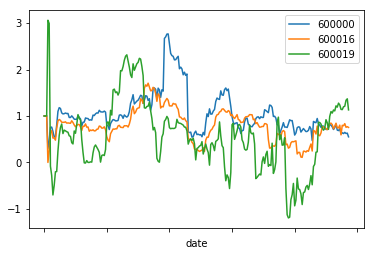

In [7]:
beta.iloc[:,0:3].plot()
plt.show()

可以看出，$\beta$的预测并不稳定，这和我们计算所用的数据偏少有关。读者可以试试用较长时间的数据来算算。
下面，我们把每只股票在一年中的$\beta$求个均值，然后画个直方图来看看$\beta$在不同股票中是如何分布的：

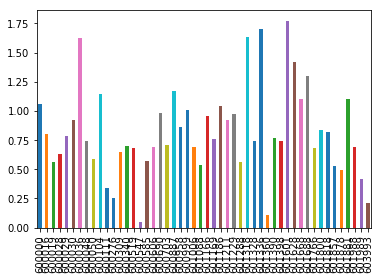

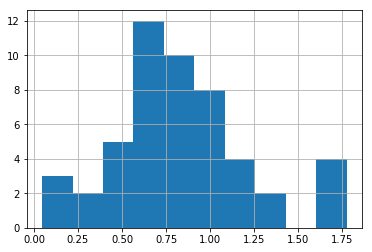

In [8]:
beta.mean().plot(kind='bar')
plt.show()
beta.mean().hist()
plt.show()

可以看出，大部分股票的$\beta$在0.6-1之间，这符合我们的认知。
但是，仅仅如此是不够的，由于我们后面会将它用于回归，
为了回归的正确性和计算的便利性，我们需要将$\beta$标准化，
使得它尽可能的接近标准正态分布。

从上图中，可以看出$\beta$还是很接近正态的，那么，我们只需给它减个均值，再除以标准差即可。而这个均值，是截面的均值；标准差，是截面的标准差。
我们先来计算均值：

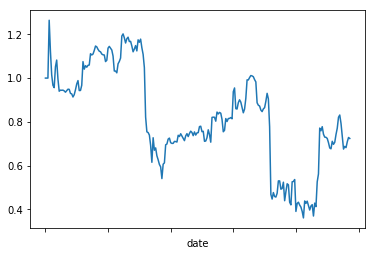

In [9]:
beta_mean = beta.mean(axis=1)
beta_mean.plot()
plt.show()

我们看到了非常奇特的图景，市场的平均$\beta$竟然会随时间有规律的变动，这一点明显需要更深入的研究和解释。

我们再算算标准差，看看能否帮助我们进一步理解这个问题：

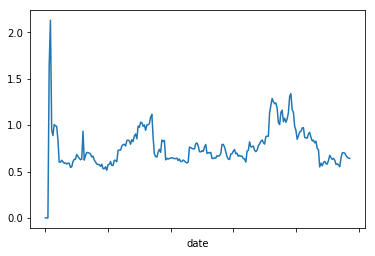

In [10]:
beta_std = beta.std(axis=1)
beta_std.plot()
plt.show()

市场中，股票$\beta$的截面波动率，同样有规律的随时间变动。我们来画个指数行情图，结合起来看看：

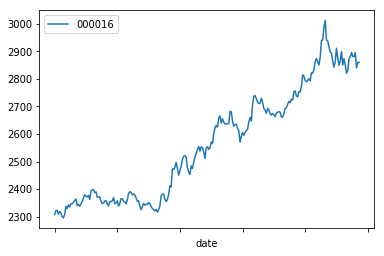

In [11]:
index_close.plot()
plt.show()

可以初步看出，在大涨的前期和大涨的后期，$\beta$的截面均值和截面标准差都出现了明显的异动。这也许对我们的交易决策会有帮助。但无论如何，我们还是要先把它标准化，再进行下一步：

In [12]:
beta_mean = np.repeat(beta_mean.values.reshape(beta_mean.size, 1), stock_list.size, axis=1)
beta_std = np.repeat(beta_std.values.reshape(beta_std.size,1), stock_list.size, axis=1)
beta_market = (beta - beta_mean) / beta_std
print(beta_market.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.094498  0.145222  0.730095 -0.418430  2.092019  0.464557   
2017-12-26 -0.051695  0.227836  0.784655 -0.455542  1.923701  0.511459   
2017-12-27 -0.130670  0.072427  0.962984 -0.638780  2.068206  0.485894   
2017-12-28 -0.151549  0.065068  0.994405 -0.660573  2.176886  0.556368   
2017-12-29 -0.269177  0.047082  0.635108 -0.819000  2.240870  0.593524   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  1.309433  0.493640  0.149876  0.401992    ...     0.134456   
2017-12-26  1.401924  0.523352 -0.213894  0.419322    ...     0.240238   
2017-12-27  1.328856  0.367624 -0.178304  0.399026    ...     0.215111   
2017-12-28  1.361056  0.493967 -0.156432  0.304358    ...     0.217752   
2017-12-29  1.379676  0.388360 -0.183

以上，我们就算出了市场因子的$\beta$。

### 6.4.2 步骤二：构造规模因子

接下来，我们来计算规模因子的$\beta$。对于规模因子，何为因子收益率，何为因子暴露？这非常容易弄错，需要特别的辨明。

一般来说，因子暴露是股票的一个固有性质，而因子收益率是市场对该因子的看法（每天会变）。正如前面的市场因子，市场因子的$\beta$是各股票各自拥有的相对稳定的属性，它跟公司所处的行业等固有属性有关。而市场收益率，也即是市场因子的因子收益率，则每天都会变动。同理，我们在使用规模因子时，因子暴露应该就是公司的市值，它虽然每天会变动，但在市场中，一只股票的市值排名则相对稳定。

由是，我们通常由两种方法来计算因子暴露：
1. Fama-French三因子模型中的算法：
    1. 把每日股票按市值大小分为三份——大中小。
    2. 用小市值股票与大市值股票在等权平均收益率上的差作为因子收益率。
    3. 然后用每只股票的超额收益率对因子收益率回归，求得$\beta$，即因子暴露。
2. 现代结构化风险模型对该类因子的通用算法：
    1. 将每日股票的市值排名拿来标准化，即得到因子暴露。
    
考虑到我们的考察期较短，股票市值排名变化不大，因子暴露也不应变化很大。
故我们采用更简单的处理方法——直接使用最新的市值，将其标准化来作为因子暴露。

我们先来获取股票的基本面数据：

In [13]:
stock_fundemental = ts.get_stock_basics()
print(stock_fundemental.head())

        name industry area    pe  outstanding  totals  totalAssets  \
code                                                                 
002940  N昂利康     化学制药   浙江  22.6         0.23    0.90     86687.72   
002445  中南文化     影视音像   江苏   0.0        12.99   14.11    768731.31   
300104   乐视网      互联网   北京   0.0        30.73   39.89   1700803.38   
600695  绿庭投资     多元金融   上海   0.0         3.66    7.11     94846.03   
002591  恒大高新     化工原料   江西  59.3         1.82    3.08    133785.81   

        liquidAssets  fixedAssets   reserved    ...     bvps     pb  \
code                                            ...                   
002940      49982.98     22901.71    9154.85    ...     6.53   5.09   
002445     332507.81     54210.56  203131.81    ...     3.03   0.89   
300104     784197.25     45031.34  864323.38    ...    -0.12 -25.45   
600695      23479.00      1892.49   38475.90    ...     0.91   3.47   
002591      44096.90     17396.07   85560.96    ...     3.78   1.59   

        tim

然后，我们获取我们股票池中股票总市值：

In [14]:
stock_assets = stock_fundemental.totalAssets[stock_list]
print(stock_assets.head())

code
600000    609175872.0
600016    606114304.0
600019     35180200.0
600028    161730400.0
600029     22911800.0
Name: totalAssets, dtype: float64


可以画个图看看总市值的分布情况：

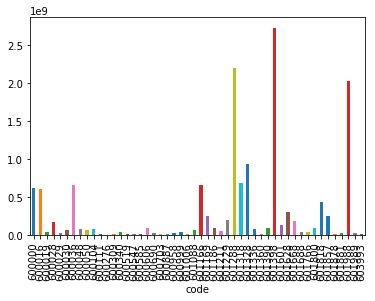

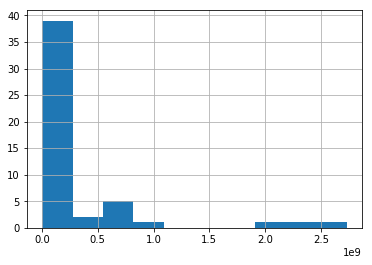

In [15]:
stock_assets.plot(kind='bar')
plt.show()
stock_assets.hist()
plt.show()

现在，我们用两种方法来将其标准化：

#### 6.4.2.1 直接把市值拿来标准化

从上图中，我们可以看出来，市值的分布并不均匀，偏度非常大。如果直接减均值再除以标准差，是很无效的。所以，我们要先把他变得接近正态分布。

面对这种数量级差异大的数据，我们的手法是取对数：

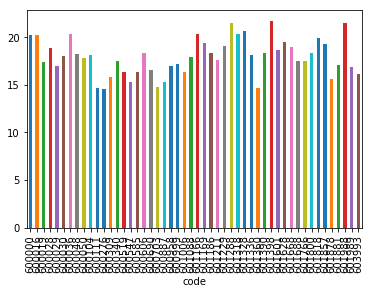

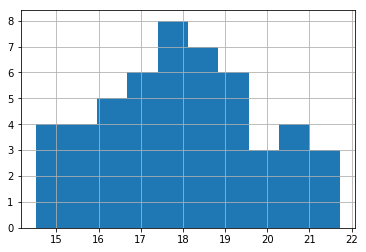

In [16]:
beta_assets = np.log(stock_assets)
beta_assets.plot(kind='bar')
plt.show()
beta_assets.hist()
plt.show()

这样，数据看起来更接近正态分布了，我们可以用和市场因子一样的方法标准化：

In [17]:
beta_assets = (beta_assets - beta_assets.mean()) / beta_assets.std()
print(beta_assets.head())

code
600000    1.219103
600016    1.216427
600019   -0.295297
600028    0.514816
600029   -0.523035
Name: totalAssets, dtype: float64


#### 6.4.2.2 把市值先排名再标准化

我们也可以先把市值拿来排名，然后再标准化。这项技术我们在第四章讲截面预测的时候用过，我们这里再用一次，权当复习了。先排名：

In [18]:
stock_assets_rank = stock_assets.rank(ascending=False)
print(stock_assets_rank.head())

code
600000     8.0
600016     9.0
600019    32.0
600028    16.0
600029    35.0
Name: totalAssets, dtype: float64


然后转化为分位数：

In [19]:
stock_assets_quantile = stock_assets_rank / (stock_list.size + 1)
print(stock_assets_quantile.head())

code
600000    0.156863
600016    0.176471
600019    0.627451
600028    0.313725
600029    0.686275
Name: totalAssets, dtype: float64


然后映射到正态分布：

code
600000   -1.007436
600016   -0.928899
600019    0.325110
600028   -0.485318
600029    0.485318
Name: totalAssets, dtype: float64


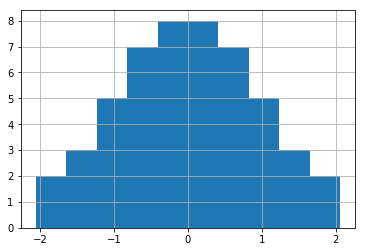

In [20]:
beta_assets = stock_assets_quantile.apply(stats.norm(0,1).ppf)
print(beta_assets.head())
beta_assets.hist()
plt.show()

以上两种方法都是可以的，第二种方法也可以应用于前面的市场因子。不过，由于第二种方法损失了相当多的距离信息，所以在对原始数据变换不多的时候，不太倾向于使用。而当我们因正态原因不得不对原始数据进行重大变换时，第二种方法相对来说，就更倾向于使用了。

不过，总的来说，两种方法都还不错。

### 6.4.3 步骤三：构造成长因子

接下来，我们构造成长因子。在Fama-French三因子模型中，账面市值比是衡量成长因子的指标，即市净率。但在国内，市盈率的使用要更为普遍。所以，我们在这里也使用市盈率作为衡量成长因子的指标。

构造成长因子的方法和规模因子类似，也是两种方法：
1. 直接使用市盈率，将其标准化
2. 讲市盈率排名，在映射到正态分布上

我们在这里重点介绍第一种方法，而把第二种方法留作课堂练习。

我们先获取市盈率，并画图观察。

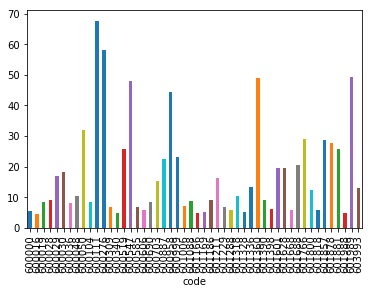

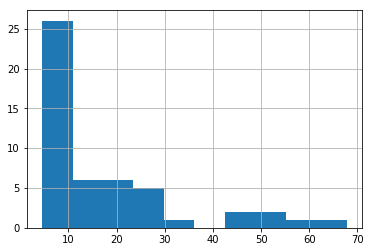

In [21]:
stock_value = stock_fundemental.pe[stock_list]
stock_value.plot(kind='bar')
plt.show()
stock_value.hist()
plt.show()

其分布差异仍然很大，不太接近正态分布。
我们先用方法一来标准化，先取对数看看：

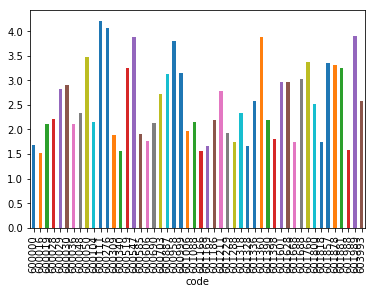

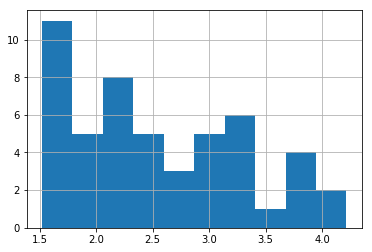

In [22]:
beta_value = np.log(stock_value)
beta_value.plot(kind='bar')
plt.show()
beta_value.hist()
plt.show()

其分布差异仍然很大，不太接近正态分布。
我们取重对数看看：

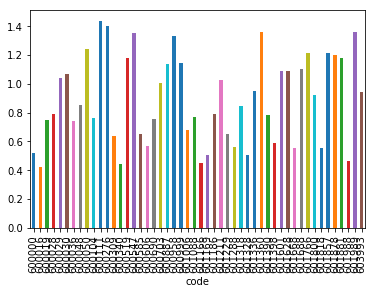

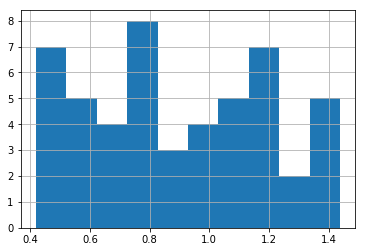

In [23]:
beta_value = np.log(np.log(stock_value))
beta_value.plot(kind='bar')
plt.show()
beta_value.hist()
plt.show()

这下看起来要好多了，我们在用减均值除以标准差的方法来标准化：

In [24]:
beta_value = (beta_value - beta_value.mean()) / beta_value.std()
print(beta_value.head())

code
600000   -1.232028
600016   -1.566282
600019   -0.478348
600028   -0.329521
600029    0.491477
Name: pe, dtype: float64


下面，请读者使用方法二来把市盈率排名映射到标准正态分布，以作为价值因子的因子暴露：

In [25]:
#使用方法二：把市盈率排名映射到标准正态分布

### 6.4.4 步骤四：计算风险——协方差矩阵

所谓风险，是因子收益率的协方差矩阵，那么我们需要先计算因子收益率。

前面，我们已经计算了因子暴露，因子收益率就是个股每日的收益率对个股每日的因子暴露进行截面回归的结果。这个过程看起来比较繁琐，但在Python中，几行代码就可以搞定：

In [26]:
factor_rtn = stock_0.iloc[:,0:3].copy()
factor_rtn.columns = ['market', 'assets', 'values']
for i in range(3, len(factor_rtn)):
    Y = stock_rtn.iloc[i].values.copy()
    X = pd.DataFrame([beta_market.iloc[i], beta_assets, beta_value])
    X = np.asarray(X).T 
    res = api.OLS(Y, X).fit()
    factor_rtn.iloc[i] = res.params

print(factor_rtn.tail())

              market    assets    values
date                                    
2017-12-25  0.000553  0.001857 -0.005465
2017-12-26  0.001565 -0.004121  0.003567
2017-12-27 -0.011953 -0.001699 -0.002233
2017-12-28  0.001007  0.006651  0.003871
2017-12-29  0.000301  0.000842 -0.004643


这就算出了因子收益率，我们画图看看因子收益率的变化：

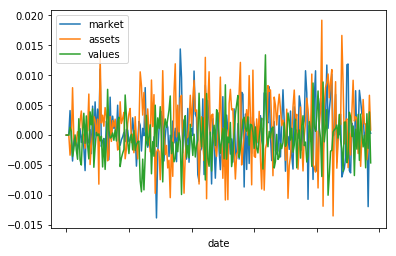

In [27]:
factor_rtn.plot()
plt.show()

直接看收益率，好像并没有什么规律，我们看看累积收益率的图呢：

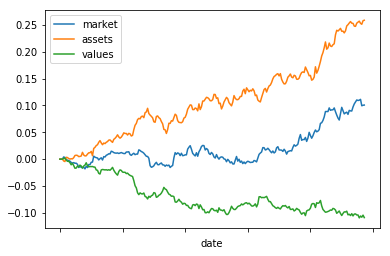

In [28]:
factor_rtn.cumsum().plot()
plt.show()

这样可以看出非常明显的规律，我们把行情图也画在下面：

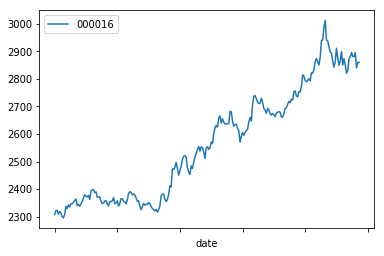

In [29]:
index_close.plot()
plt.show()

可以看出：
1. 市场因子的累积因子收益率明显和市场指数一致变化
2. 规模因子的累积因子收益率持续上升，说明大盘股的表现大幅超越小盘股。这和我们的认知相同，2017年是个去杠杆的年份，小市值股票表现不好。
3. 成长因子的累计因子收益率持续下降，说明经济不景气，成长股受到的影响较大，这也和我们的认知相同。

下面我们就来算算因子收益率的协方差矩阵：

In [53]:
print("因子协方差矩阵：")
factor_rtn_cov = factor_rtn.cov()
print(factor_rtn_cov)
print("因子相关系数矩阵：")
print(factor_rtn.corr())
print("股票协方差矩阵：")
beta_all = pd.DataFrame([beta_market.iloc[-1], beta_assets, beta_value], index=['market','assets', 'value'])
stock_rtn_cov = np.dot(np.dot(beta_all.T, factor_rtn.cov()), beta_all)
print(stock_rtn_cov)

因子协方差矩阵：
              market    assets        values
market  1.954905e-05  0.000004 -5.336970e-07
assets  3.657541e-06  0.000029 -1.168094e-05
values -5.336970e-07 -0.000012  1.274312e-05
因子相关系数矩阵：
          market    assets    values
market  1.000000  0.153623 -0.033814
assets  0.153623  1.000000 -0.607672
values -0.033814 -0.607672  1.000000
股票协方差矩阵：
[[ 2.28213511e-05  2.02248042e-05 -8.59082527e-06 ...  3.28028727e-05
  -7.39354494e-06 -1.13394987e-06]
 [ 2.02248042e-05  2.20939157e-05  5.74324147e-07 ...  2.68034477e-05
  -1.76872230e-05 -6.65040928e-06]
 [-8.59082527e-06  5.74324147e-07  1.93338044e-05 ... -1.69982632e-05
  -1.88214700e-05 -9.44753950e-06]
 ...
 [ 3.28028727e-05  2.68034477e-05 -1.69982632e-05 ...  5.00012936e-05
  -6.66982762e-06 -8.41843078e-06]
 [-7.39354494e-06 -1.76872230e-05 -1.88214700e-05 ... -6.66982762e-06
   3.48411386e-05  2.82075479e-05]
 [-1.13394987e-06 -6.65040928e-06 -9.44753950e-06 ... -8.41843078e-06
   2.82075479e-05  6.77352546e-05]]


为直观的看看股票间的相关关系，我们对协防差矩阵画热力图：

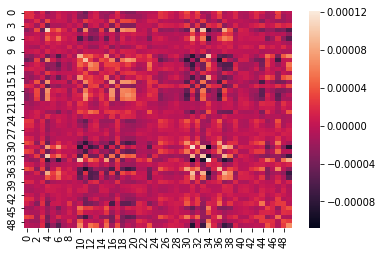

In [54]:
import seaborn as sns
sns.heatmap(stock_rtn_cov)
plt.show()

这里我们用到了一个包Seaborn，它是在matplotlib的基础上进行了更高级的API封装，从而使得作图更容易了。它给我们提供了很多非常不错的数据可视化方案。是值得学习的一个包。具体使用手册可参见：

http://seaborn.pydata.org/

以上，我们就成功的对股票风险建模了。 关于风险模型中的特异风险，涉及技巧较多，且方法多样， 业界并无孰优孰劣之定论，故我们暂且不作深入研究。

## 6.5 延伸阅读——怎样的风险预测模型是好的模型？

首先，如何定义风险，这就已经众说纷纭了。

从本质来看，风险就是对未来收益的不确定性的度量。
那既然未来收益是不确定的，那我们几乎可以把它看作一个随机变量。
那其实风险就是该随机变量的分布函数的度量。
一个随机变量的分布可以完全由它的无穷阶矩度量，
我们选取影响最大的一阶矩和二阶矩来考虑问题。
很明显，一阶矩就是收益，二阶矩度量风险是很合适的。

实际上，收益分布的方差是度量量风险的好指标。
其他度量风险的指标，相较之下，并不能提供太多的信息增量，
同时又增加了各式各样的弱点。
再者考虑到数学性质较好的还是方差，
所以，最终，绝大部分人都选择了方差作为风险的度量。

其它常用的还有：
1. 半方差
2. 目标半方差
3. 损失概率
4. 在险价值
这些就不再赘述。

那么怎样预测风险呢？即怎样预测未来的标准差呢？

早期，人们通过对行情的观察和统计分析，
发现波动率具有聚集的特征。
这意味着方差/标准差可以用时间序列这门学科中的工具来处理，
于是诞生了ARCH/GARCH及其衍生模型。
这虽然能对波动率进行部分的预测，
但仍然是远远不够的。
后来，人们逐渐从单因素模型和Fama-French三因子模型中体会到，
只要有了因子暴露，就可以从因子协方差矩阵推导出股票的协方差矩阵。
而同时，因子的协方差矩阵还相对容易得到。
这样，人们就逐渐开发出了多因子结构化模型。
以Barra为代表的风险模型逐渐诞生。

结构化风险模型线性的组合了多种风险因子，
这些风险因子大都具有较强的经济学解释，
能很好的解释风险模型的结果，让人不得不信服。
另外，对于因子不能解释的风险，又通过传统的数学方法来处理，
从理论上几乎做到了完美。

那实践中呢？模型是否比其他模型要好呢？
一些人用实际数据做了验证，将结构化风险模型和历史数据法、GARCH法做了比较。
用不同的模型站在t时刻预测t+1时刻的标准差，
统计1倍/2倍标准差之外的事件的发生频率。
由大数定律，频率会收敛到概率。
我们可以得出哪个模型对未来风险的预测更接近事实。

结果，实践中，当因子选得足够好时，
结构化风险模型的效果是远好于其他模型的。
这样，也坚定了人们使用这个模型的信念。

读者也可以自行设计实验来验证这点。